In [ ]:
!pip install maxfuse

In [115]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

In [116]:
protein = pd.read_csv('/content/Protein.csv', index_col=0)
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [117]:
rna = pd.read_csv('/content/scRNA_Seq.csv', index_col=0)
rna_adata = ad.AnnData(
    rna.to_numpy(), dtype=np.float32
)
rna_adata.var_names = rna.columns

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
rna.shape
#protein.shape

(10000, 2000)

In [ ]:
# read in celltyle labels
metadata = pd.read_csv('../data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

protein_adata.obs['celltype.l1'] = labels_l1
protein_adata.obs['celltype.l2'] = labels_l2
rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2

In [118]:
correspondence = pd.read_csv('/content/protein_gene_conversion.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


In [119]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)

In [ ]:
rna_protein_correspondence

In [120]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [121]:
protein_shared.shape

(10000, 95)

In [ ]:
protein_shared.obs.keys()

Index([], dtype='object')

In [122]:
# Make sure no column is static
mask = (
    (rna_shared.X.std(axis=0) > 1e-5)
    & (protein_shared.X.std(axis=0) > 1e-5)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [123]:
# row sum for RNA
rna_counts = rna_shared.X.sum(axis=1)
# row sum for protein
protein_counts = protein_shared.X.sum(axis=1)
# take median of each and then take mean
target_sum = (np.median(rna_counts.copy()) + np.median(protein_counts.copy())) / 2

In [124]:
# process rna_shared
sc.pp.normalize_total(rna_shared, target_sum=target_sum)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)

In [125]:
sc.pp.neighbors(rna_shared, n_neighbors=15)

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 95 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


In [126]:
rna_shared = rna_shared.X.copy()

In [127]:
# process protein_shared
sc.pp.normalize_total(protein_shared, target_sum=target_sum)
sc.pp.log1p(protein_shared)
sc.pp.scale(protein_shared)

In [128]:
sc.pp.neighbors(protein_shared, n_neighbors=15)
sc.tl.umap(protein_shared)

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 95 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


In [129]:
protein_shared = protein_shared.X.copy()

In [130]:
# process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata)
# only retain highly variable genes
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

In [131]:
sc.pp.neighbors(rna_adata, n_neighbors=15)
sc.tl.umap(rna_adata)

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 272 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


In [132]:
# process all protein features
sc.pp.normalize_total(protein_adata)
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)

In [133]:
sc.pp.neighbors(protein_adata, n_neighbors=15)
sc.tl.umap(protein_adata)

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 224 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


In [134]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5]

In [135]:
# inspect shape of the four matrices
print(rna_active.shape)
print(protein_active.shape)
print(rna_shared.shape)
print(protein_shared.shape)

(10000, 272)
(10000, 224)
(10000, 95)
(10000, 95)


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimCLR_Autoencoder(nn.Module):
    def __init__(self, input_dim_rna, input_dim_protein, latent_dim, shared_dim, projection_dim):
        super(SimCLR_Autoencoder, self).__init__()

        # RNA Encoder
        self.encoder_rna = nn.Sequential(
            nn.Linear(input_dim_rna, 128),
            nn.ReLU(),
            nn.Linear(128, shared_dim)  # Maps to shared latent space
        )

        # Protein Encoder
        self.encoder_protein = nn.Sequential(
            nn.Linear(input_dim_protein, 128),
            nn.ReLU(),
            nn.Linear(128, shared_dim)  # Maps to shared latent space
        )

        # Projection head for contrastive loss
        self.projection_head = nn.Sequential(
            nn.Linear(shared_dim, 64),
            nn.ReLU(),
            nn.Linear(64, projection_dim)  # Final contrastive space
        )

        # RNA Decoder
        self.decoder_rna = nn.Sequential(
            nn.Linear(shared_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim_rna)  # Reconstruct RNA
        )

        # Protein Decoder
        self.decoder_protein = nn.Sequential(
            nn.Linear(shared_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim_protein)  # Reconstruct Protein
        )

    def forward(self, x_rna, x_protein):
        # Encode
        z_rna = self.encoder_rna(x_rna)
        z_protein = self.encoder_protein(x_protein)

        # Shared latent space
        shared_latent = (z_rna + z_protein) / 2

        # Project embeddings for contrastive loss
        proj_rna = self.projection_head(z_rna)
        proj_protein = self.projection_head(z_protein)

        # Decode
        rna_recon = self.decoder_rna(shared_latent)
        protein_recon = self.decoder_protein(shared_latent)

        return rna_recon, protein_recon, proj_rna, proj_protein


In [90]:
def contrastive_loss(z_rna, z_protein, temperature=0.5):
    """
    Compute contrastive loss using NT-Xent.
    """
    batch_size = z_rna.shape[0]

    # Normalize vectors
    z_rna = F.normalize(z_rna, dim=1)
    z_protein = F.normalize(z_protein, dim=1)

    # Compute similarity matrix
    sim_matrix = torch.matmul(z_rna, z_protein.T) / temperature  # Cosine similarity

    # Create labels (positive pairs along diagonal)
    labels = torch.arange(batch_size).to(z_rna.device)

    # NT-Xent loss
    loss = F.cross_entropy(sim_matrix, labels)
    return loss


In [95]:
# Define model
input_dim_rna = 272
input_dim_protein = 224
latent_dim = 64
shared_dim = 32  # Shared latent space
projection_dim = 16  # Projection space for contrastive loss

model = SimCLR_Autoencoder(input_dim_rna, input_dim_protein, latent_dim, shared_dim, projection_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train_simclr(model, rna_data, protein_data, epochs=100, temperature=0.5):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        rna_recon, protein_recon, proj_rna, proj_protein = model(rna_data, protein_data)

        # Reconstruction loss
        loss_rna = criterion(rna_recon, rna_data)
        loss_protein = criterion(protein_recon, protein_data)

        # Contrastive loss
        contrastive = contrastive_loss(proj_rna, proj_protein, temperature)

        # Total loss
        loss = loss_rna + loss_protein + 0.1 * contrastive
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Total Loss: {loss.item()}, Contrastive Loss: {contrastive.item()}")

# Convert rna_active and protein_active to tensors
rna_data = torch.tensor(rna_active, dtype=torch.float32)
protein_data = torch.tensor(protein_active, dtype=torch.float32)

# Train the model
train_simclr(model, rna_data, protein_data, epochs=300)


Epoch 0, Total Loss: 2.939302682876587, Contrastive Loss: 9.23828125
Epoch 10, Total Loss: 2.721465587615967, Contrastive Loss: 8.368736267089844
Epoch 20, Total Loss: 2.4617466926574707, Contrastive Loss: 8.192319869995117
Epoch 30, Total Loss: 2.265010356903076, Contrastive Loss: 8.121785163879395
Epoch 40, Total Loss: 2.1701500415802, Contrastive Loss: 8.058793067932129
Epoch 50, Total Loss: 2.1114752292633057, Contrastive Loss: 8.00028133392334
Epoch 60, Total Loss: 2.065648078918457, Contrastive Loss: 7.933410167694092
Epoch 70, Total Loss: 2.026062488555908, Contrastive Loss: 7.8718414306640625
Epoch 80, Total Loss: 1.9918454885482788, Contrastive Loss: 7.831192970275879
Epoch 90, Total Loss: 1.9637341499328613, Contrastive Loss: 7.801514148712158
Epoch 100, Total Loss: 1.94126296043396, Contrastive Loss: 7.775711536407471
Epoch 110, Total Loss: 1.922581434249878, Contrastive Loss: 7.754805564880371
Epoch 120, Total Loss: 1.906092643737793, Contrastive Loss: 7.738222599029541
Epo

In [96]:
# Get final embeddings for clustering
model.eval()
with torch.no_grad():
    z_rna = model.encoder_rna(rna_data)
    z_protein = model.encoder_protein(protein_data)

# Combine RNA & Protein embeddings into 20,000 points
final_embedding = torch.cat([z_rna, z_protein], dim=0).numpy()

# Apply Spectral Clustering
from sklearn.cluster import SpectralClustering

num_clusters = 8
spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=42)
cluster_labels_simclr = spectral.fit_predict(final_embedding)

print("Spectral Clustering Labels:", cluster_labels_simclr)


Spectral Clustering Labels: [3 3 1 ... 0 4 2]


In [97]:
cell_ids = np.concatenate([rna.index, protein.index])
cluster_df = pd.DataFrame({'Index': cell_ids, 'Expected': cluster_labels_simclr})
cluster_df.to_csv('clustering_predictions_maxfuse_spectral_simclr2.csv', index=False)

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim

class DualAutoencoder(nn.Module):
    def __init__(self, input_dim_rna, input_dim_protein, latent_dim, shared_dim):
        super(DualAutoencoder, self).__init__()

        # RNA Encoder
        self.encoder_rna = nn.Sequential(
            nn.Linear(input_dim_rna, 128),
            nn.ReLU(),
            nn.Linear(128, shared_dim)  # Maps to shared latent space
        )

        # Protein Encoder
        self.encoder_protein = nn.Sequential(
            nn.Linear(input_dim_protein, 128),
            nn.ReLU(),
            nn.Linear(128, shared_dim)  # Maps to shared latent space
        )

        # RNA Decoder
        self.decoder_rna = nn.Sequential(
            nn.Linear(shared_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim_rna)  # Reconstruct RNA
        )

        # Protein Decoder
        self.decoder_protein = nn.Sequential(
            nn.Linear(shared_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim_protein)  # Reconstruct Protein
        )

    def forward(self, x_rna, x_protein):
        # Encode
        z_rna = self.encoder_rna(x_rna)
        z_protein = self.encoder_protein(x_protein)

        # Enforce similarity in shared space (alignment loss)
        shared_latent = (z_rna + z_protein) / 2

        # Decode
        rna_recon = self.decoder_rna(shared_latent)
        protein_recon = self.decoder_protein(shared_latent)

        return rna_recon, protein_recon, z_rna, z_protein

# Define model
input_dim_rna = 272
input_dim_protein = 224
latent_dim = 64
shared_dim = 32  # Shared latent space

model = DualAutoencoder(input_dim_rna, input_dim_protein, latent_dim, shared_dim)


In [137]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, rna_data, protein_data, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        rna_recon, protein_recon, z_rna, z_protein = model(rna_data, protein_data)

        # Reconstruction Loss
        loss_rna = criterion(rna_recon, rna_data)
        loss_protein = criterion(protein_recon, protein_data)

        # Alignment Loss (Encourage shared latent representations to be similar)
        alignment_loss = criterion(z_rna, z_protein)

        # Total Loss
        loss = loss_rna + loss_protein + 0.1 * alignment_loss
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Assuming rna_active and protein_active are already tensors
rna_data = torch.tensor(rna_active, dtype=torch.float32)
protein_data = torch.tensor(protein_active, dtype=torch.float32)

train_model(model, rna_data, protein_data, epochs=150)


Epoch 0, Loss: 2.0239524841308594
Epoch 10, Loss: 1.910105586051941
Epoch 20, Loss: 1.6735868453979492
Epoch 30, Loss: 1.4841614961624146
Epoch 40, Loss: 1.3948653936386108
Epoch 50, Loss: 1.3442518711090088
Epoch 60, Loss: 1.3041819334030151
Epoch 70, Loss: 1.269927740097046
Epoch 80, Loss: 1.2409121990203857
Epoch 90, Loss: 1.2164092063903809
Epoch 100, Loss: 1.195928692817688
Epoch 110, Loss: 1.1794477701187134
Epoch 120, Loss: 1.166218876838684
Epoch 130, Loss: 1.1552401781082153
Epoch 140, Loss: 1.1449482440948486


In [138]:
# Ensure model is in evaluation mode
model.eval()

# Forward pass to get separate latent embeddings for RNA and Protein
with torch.no_grad():
    z_rna = model.encoder_rna(rna_data)  # Shape: (10000, shared_dim)
    z_protein = model.encoder_protein(protein_data)  # Shape: (10000, shared_dim)

# Stack embeddings to get 20,000 points in the latent space
final_embedding = torch.cat([z_rna, z_protein], dim=0)  # Shape: (20000, shared_dim)

print("Final Embedding Shape:", final_embedding.shape)  # Should be (20000, shared_dim)


Final Embedding Shape: torch.Size([20000, 32])


In [103]:
final_embedding_reduced = final_embedding.numpy()
final_embedding_reduced = final_embedding_reduced[:,:10]

In [139]:
from sklearn.cluster import SpectralClustering

# Convert PyTorch tensor to NumPy array
final_embedding_np = final_embedding.numpy()
#final_embedding_np = final_embedding_reduced

# Apply Spectral Clustering
num_clusters = 8
spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral.fit_predict(final_embedding_np)

print("Spectral Clustering Labels:", cluster_labels)



Spectral Clustering Labels: [1 1 0 ... 1 0 2]


In [114]:
cell_ids = np.concatenate([rna.index, protein.index])
cluster_df = pd.DataFrame({'Index': cell_ids, 'Expected': cluster_labels})
cluster_df.to_csv('clustering_predictions_maxfuse_spectral_nn_last.csv', index=False)

In [140]:
from umap import UMAP
# Step 10: UMAP Visualization
umap = UMAP(n_components=2, random_state=42)
umap_embedding = umap.fit_transform(final_embedding_np)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


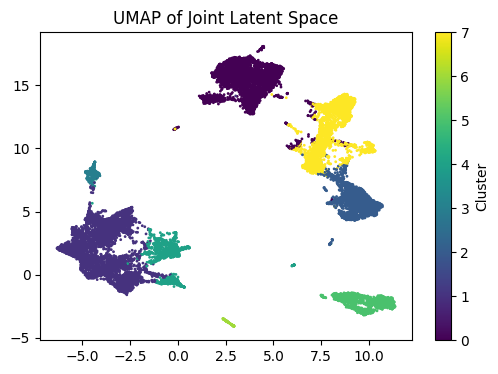

In [141]:
import matplotlib.pyplot as plt
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='viridis', s=1)
plt.colorbar(label='Cluster')
plt.title('UMAP of Joint Latent Space')
plt.show()

In [23]:


print(np.isnan(rna_shared).sum())  # Count NaNs
print(np.isinf(rna_shared).sum())  # Count infinite values


0
0


In [24]:
print(np.isnan(rna_active).sum(), np.isinf(rna_active).sum())
print(np.isnan(protein_active).sum(), np.isinf(protein_active).sum())


0 0
0 0


In [25]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [26]:
fusor.split_into_batches(
    max_outward_size=5000,
    matching_ratio=3,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
The second data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

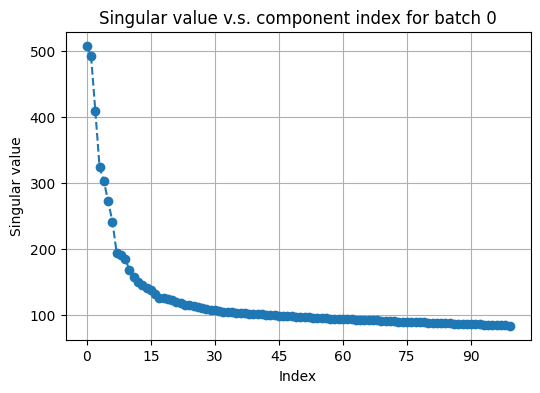

In [27]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

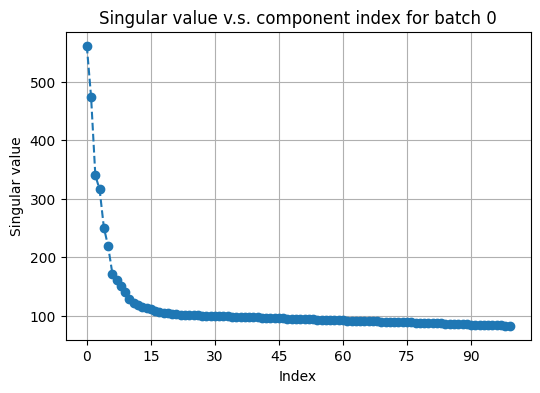

In [28]:
# plot top singular values of avtive_arr2 on a random batch
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

In [75]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=30,
    svd_components2=30,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

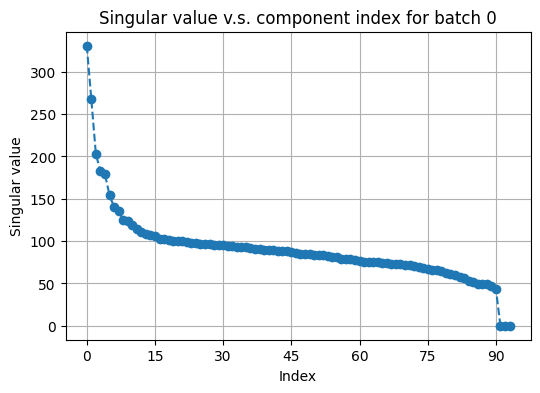

In [63]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

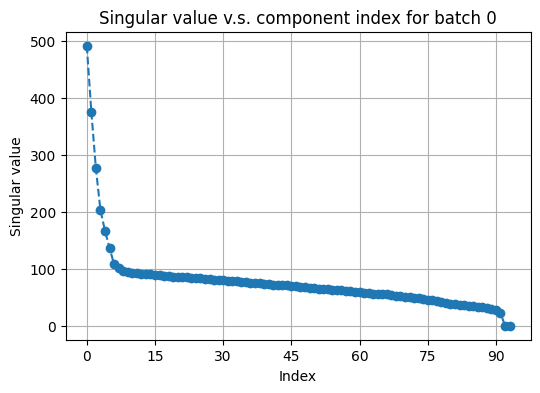

In [64]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

In [65]:
fusor.find_initial_pivots(
    wt1=0.8, wt2=0.8,
    svd_components1=25, svd_components2=20
)

Now at batch 0<->0...
Done!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

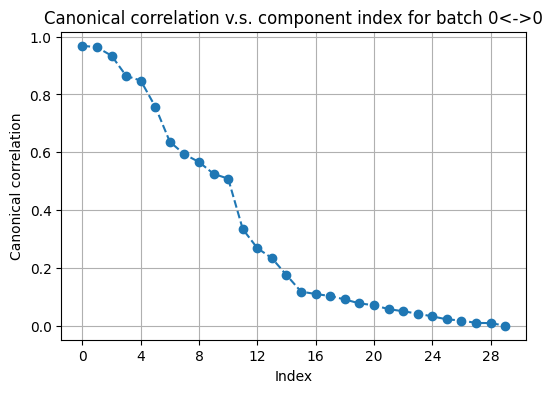

In [66]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=30,
    svd_components2=30,
    cca_components=30
)

In [67]:
fusor.refine_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=30, svd_components2=30,
    cca_components=20,
    n_iters=3,
    randomized_svd=False,
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [68]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.3)

Begin filtering...
Now at batch 0<->0...
3500/5000 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
6997/10000 cells in arr1 are selected as pivots.
3500/10000 cells in arr2 are selected as pivots.
Done!


In [69]:
pivot_matching = fusor.get_matching(target='pivot')

In [70]:
# We can inspect the first pivot pair.
[pivot_matching[0][0], pivot_matching[1][0], pivot_matching[2][0]]

[2224, 0, 0.8786851059245611]

In [71]:
rna_cca, protein_cca = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)

In [ ]:
rna_cca.shape

(10000, 20)

In [ ]:
protein_cca.shape

(10000, 20)

In [39]:
dim_use = 15

mf.metrics.get_foscttm(
    dist=mf.utils.cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),
    true_matching='identity'
)

0.12632136

In [58]:
dim_use = 10

cca_adata = ad.AnnData(
    np.concatenate((rna_cca[:,:dim_use], protein_cca[:,:dim_use]), axis=0),
    dtype=np.float32
)
cca_adata.obs['data_type'] = ['rna'] * rna_cca.shape[0] + ['protein'] * protein_cca.shape[0]

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
cca_adata

AnnData object with n_obs × n_vars = 20000 × 10
    obs: 'data_type'

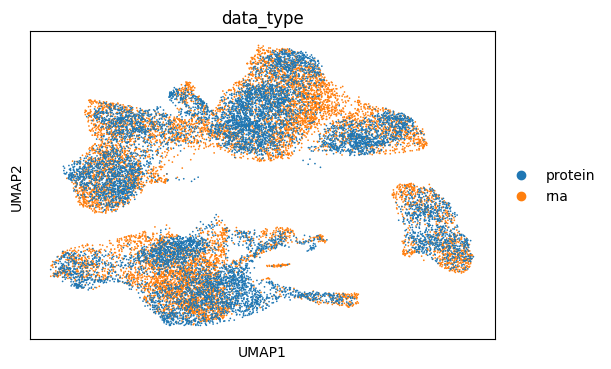

In [41]:
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)
sc.pl.umap(cca_adata, color='data_type')

In [72]:
joint_embedding = np.concatenate([rna_cca[:,:10], protein_cca[:,:10]], axis=0)


In [43]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Assuming joint_embedding is already defined
num_clusters = 8

# Apply GMM
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm_labels = gmm.fit_predict(joint_embedding)

In [44]:
cell_ids = np.concatenate([rna.index, protein.index])
cluster_df = pd.DataFrame({'Index': cell_ids, 'Expected': gmm_labels})
cluster_df.to_csv('clustering_predictions_maxfuse_gmm.csv', index=False)

In [45]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.1 MB/s eta 0:00:00


In [46]:
import skfuzzy as fuzz

# Transpose because skfuzzy expects (features, samples)
joint_embedding_T = joint_embedding.T

# Apply Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    joint_embedding_T, num_clusters, m=2, error=0.005, maxiter=1000, init=None
)

# Assign points to the cluster with the highest membership probability
fcm_labels = np.argmax(u, axis=0)

In [47]:
cell_ids = np.concatenate([rna.index, protein.index])
cluster_df = pd.DataFrame({'Index': cell_ids, 'Expected': fcm_labels})
cluster_df.to_csv('clustering_predictions_maxfuse_fcm.csv', index=False)

In [ ]:
joint_embedding.shape

(20000, 10)

In [73]:
from sklearn.cluster import SpectralClustering

# Define the Spectral Clustering model
n_clusters = 8
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)

# Fit the model and predict cluster labels
cluster_labels_spectral = spectral.fit_predict(joint_embedding)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=42).fit(joint_embedding)
cluster_labels = kmeans.labels_


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Define the model with 8 clusters
hclust = AgglomerativeClustering(n_clusters=8, linkage='ward')

# Fit and predict cluster labels
cluster_labels_heir = hclust.fit_predict(joint_embedding)

In [ ]:
from umap import UMAP
# Step 10: UMAP Visualization
umap = UMAP(n_components=2, random_state=42)
umap_embedding = umap.fit_transform(joint_embedding)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [74]:
# Step 11: Save Clustering Results
cell_ids = np.concatenate([rna.index, protein.index])
cluster_df = pd.DataFrame({'Index': cell_ids, 'Expected': cluster_labels_spectral})
cluster_df.to_csv('clustering_predictions_maxfuse_spectral3.csv', index=False)


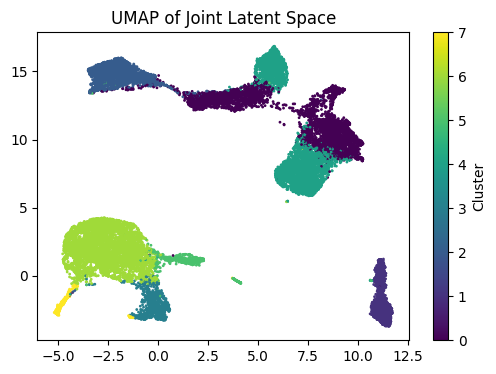

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='viridis', s=1)
plt.colorbar(label='Cluster')
plt.title('UMAP of Joint Latent Space')
plt.show()